In [1]:
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt
import qujax
import jax
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

def expected_kernel(kernel, data1, weights1, data2, weights2):
    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()


def mmd(kernel, data1, weights1, data2, weights2):
    return (
        expected_kernel(kernel, data1, weights1, data1, weights1)
        - 2 * expected_kernel(kernel, data1, weights1, data2, weights2)
        + expected_kernel(kernel, data2, weights2, data2, weights2)
    )

def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params


def gaussian_kernel(s1, s2):
    return jnp.exp(-jnp.square(s1 - s2) / bandwidth_sq)


def param_to_mmd(param):
    data_probs = jnp.ones(5000) / 5000
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, data, data_probs)

def param_to_mmd_stochastic(param, batch_size = 200):
    data_probs = jnp.ones(batch_size) / batch_size
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, np.random.choice(data, batch_size), data_probs)

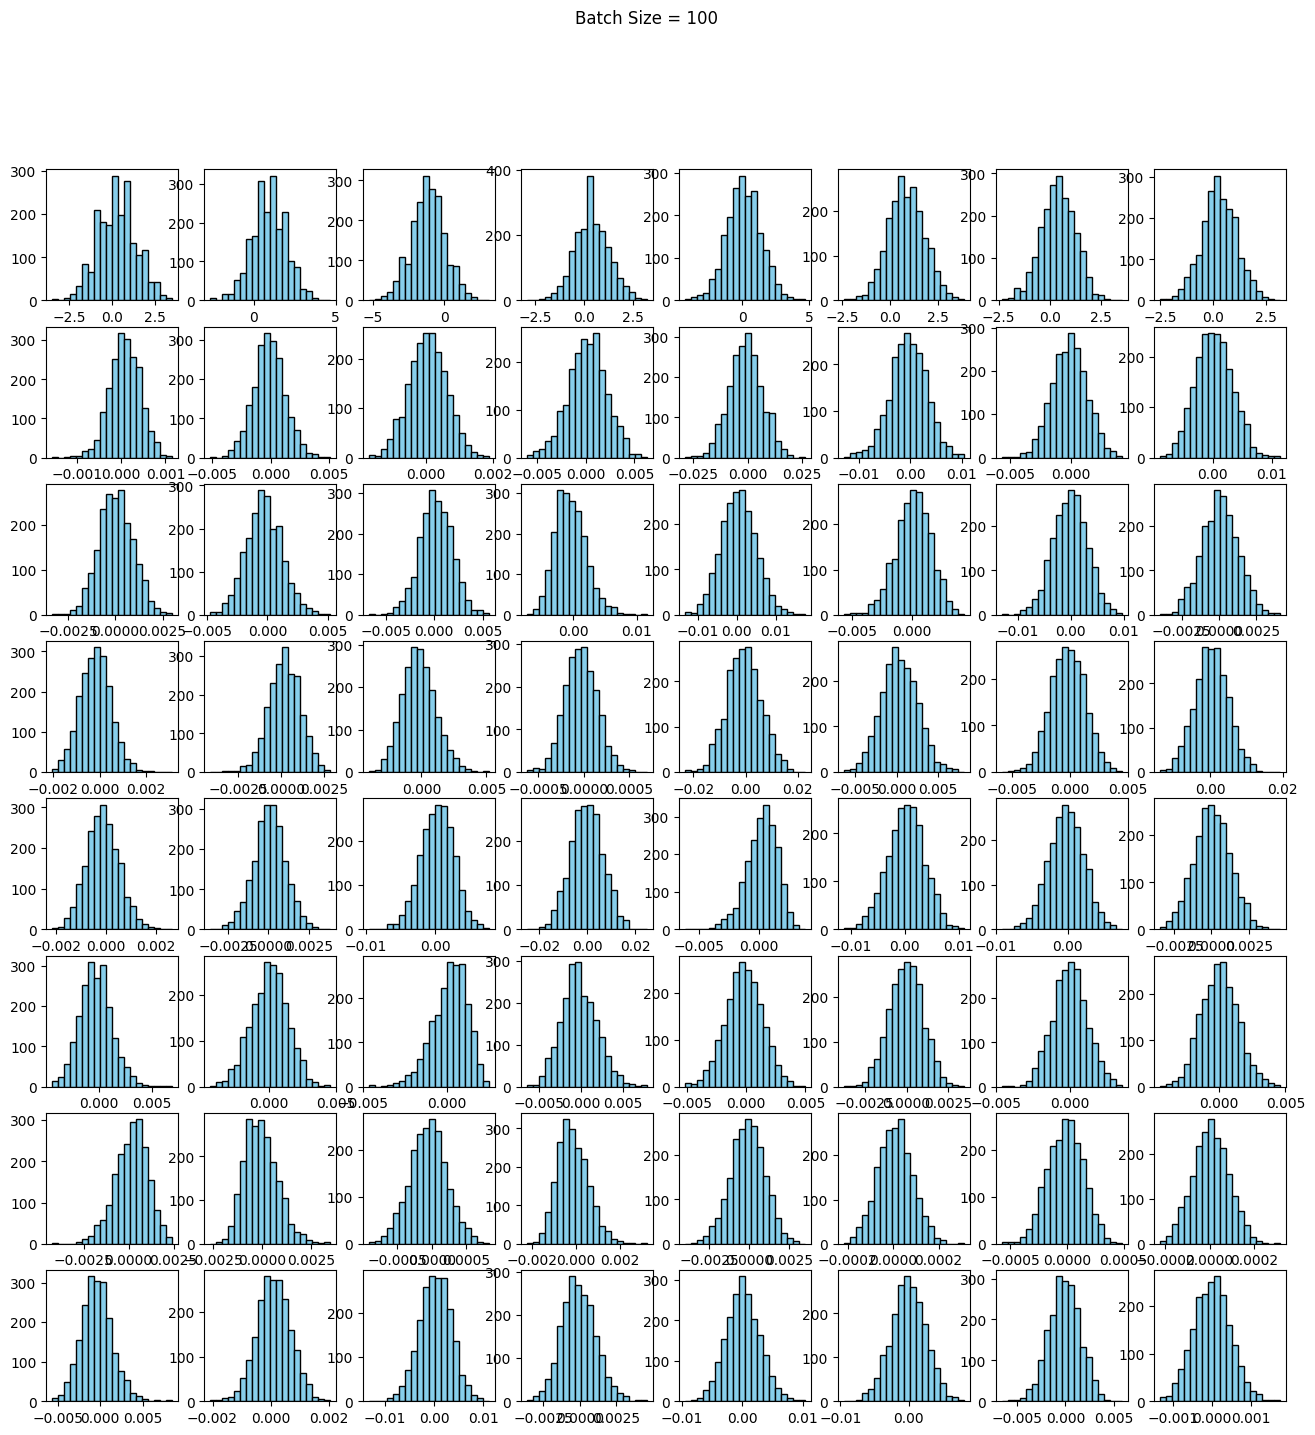

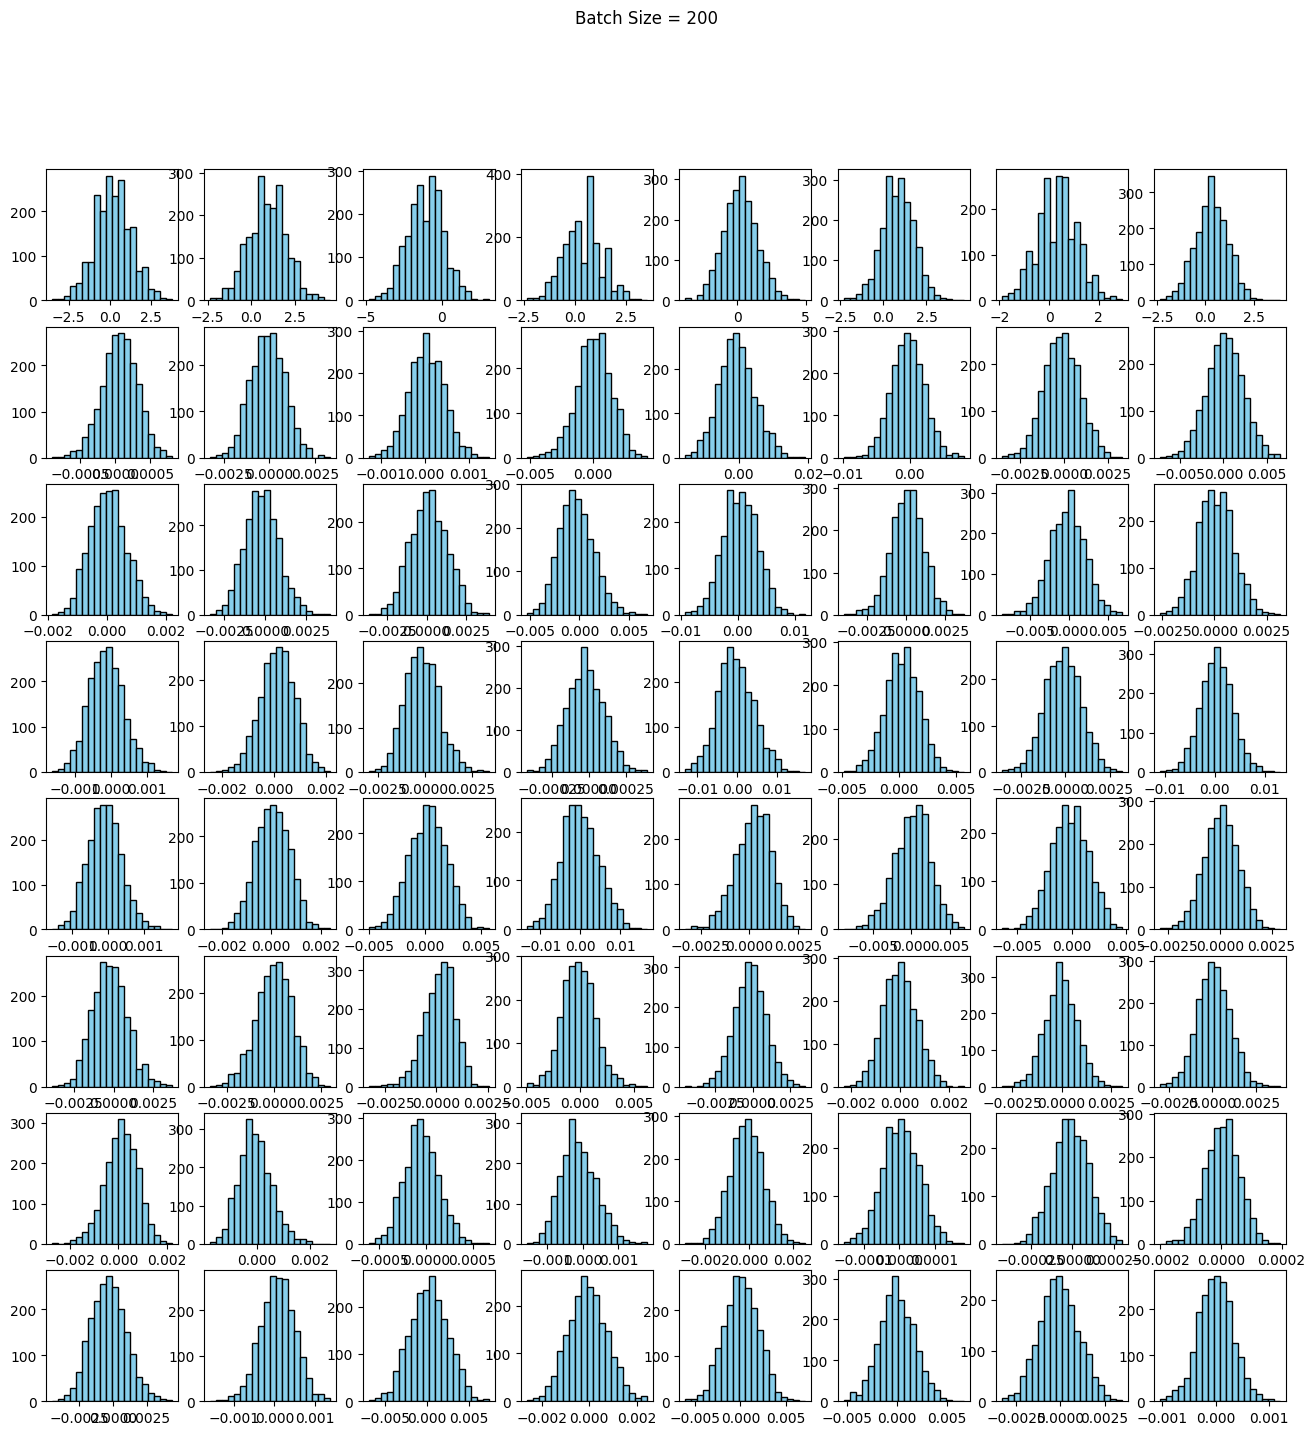

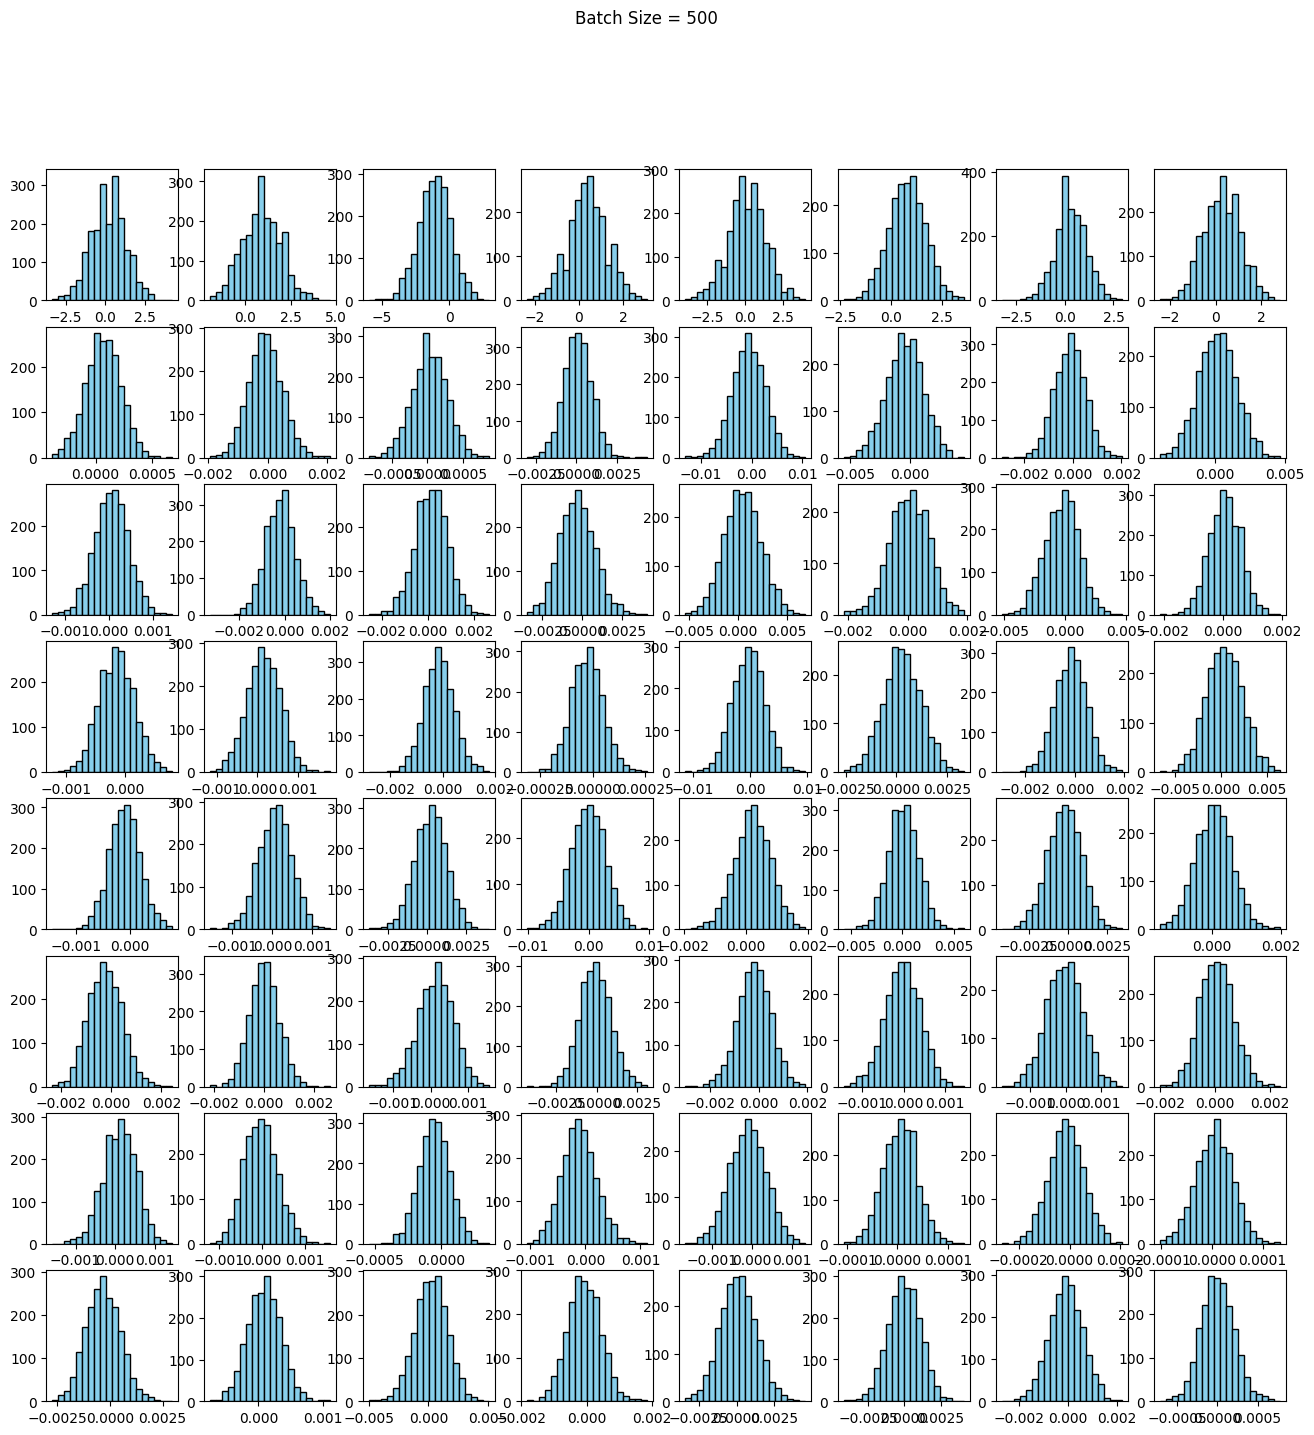

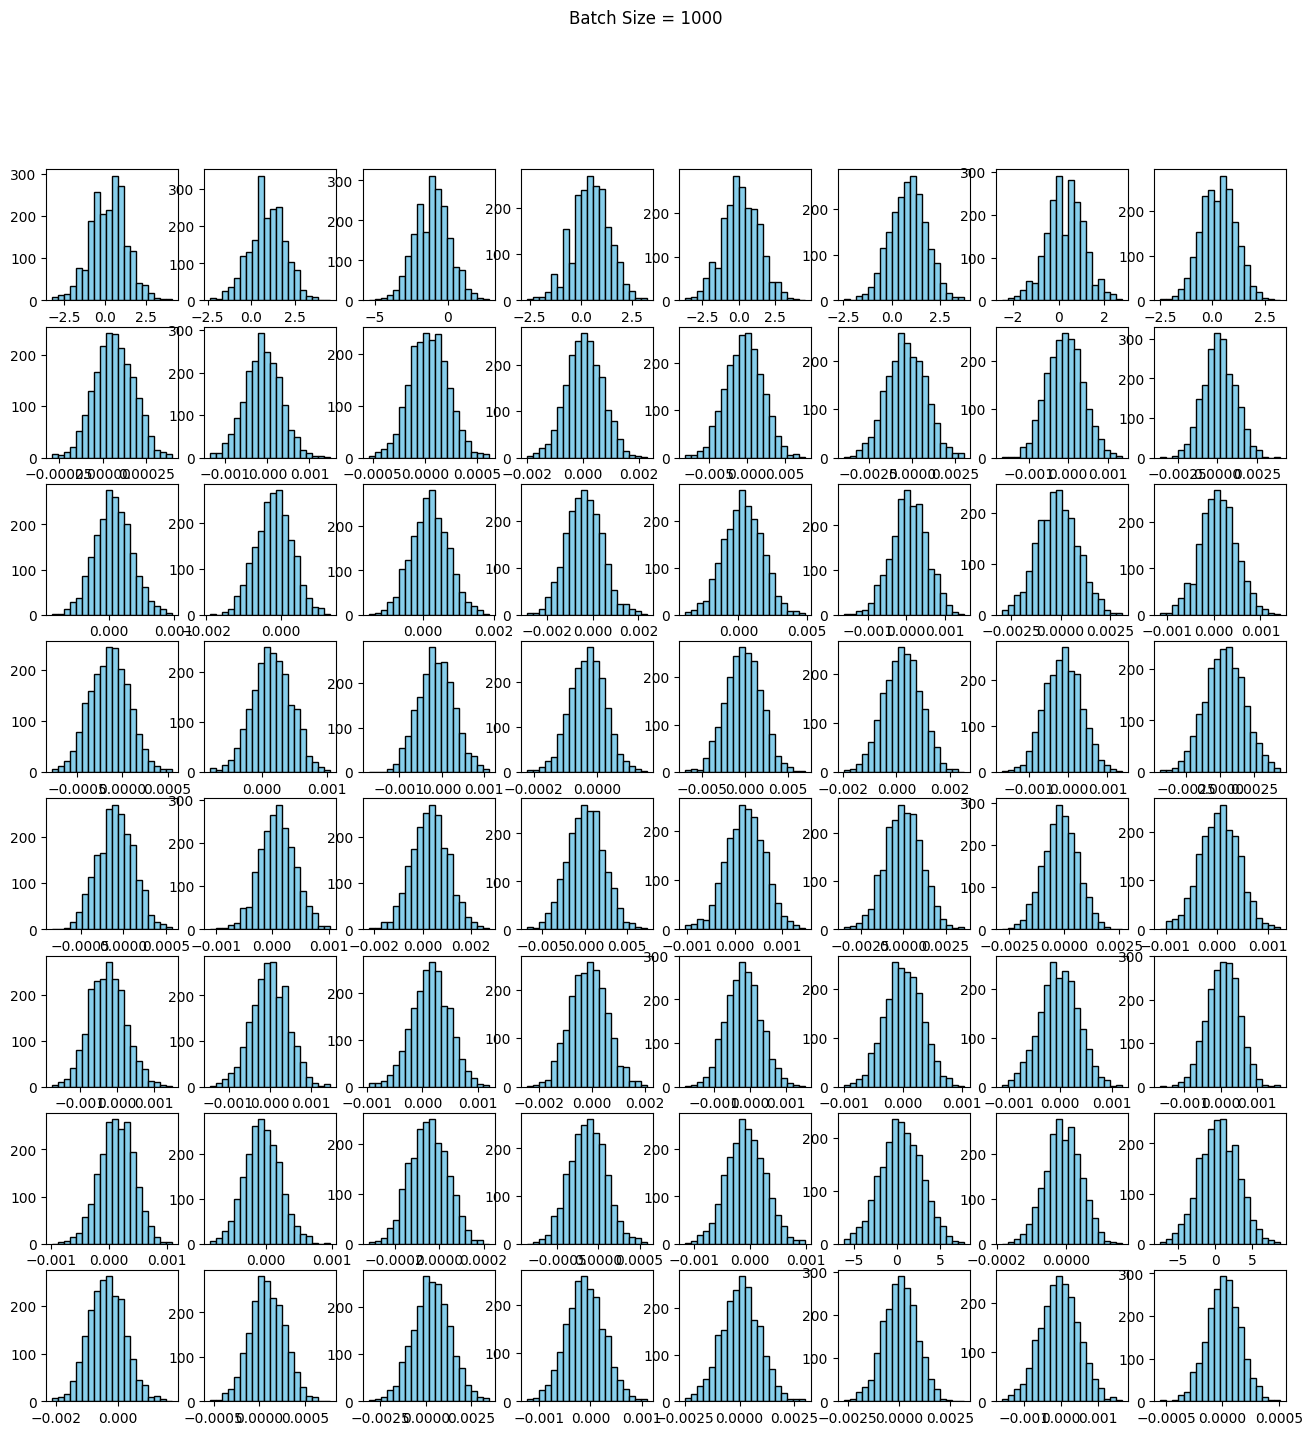

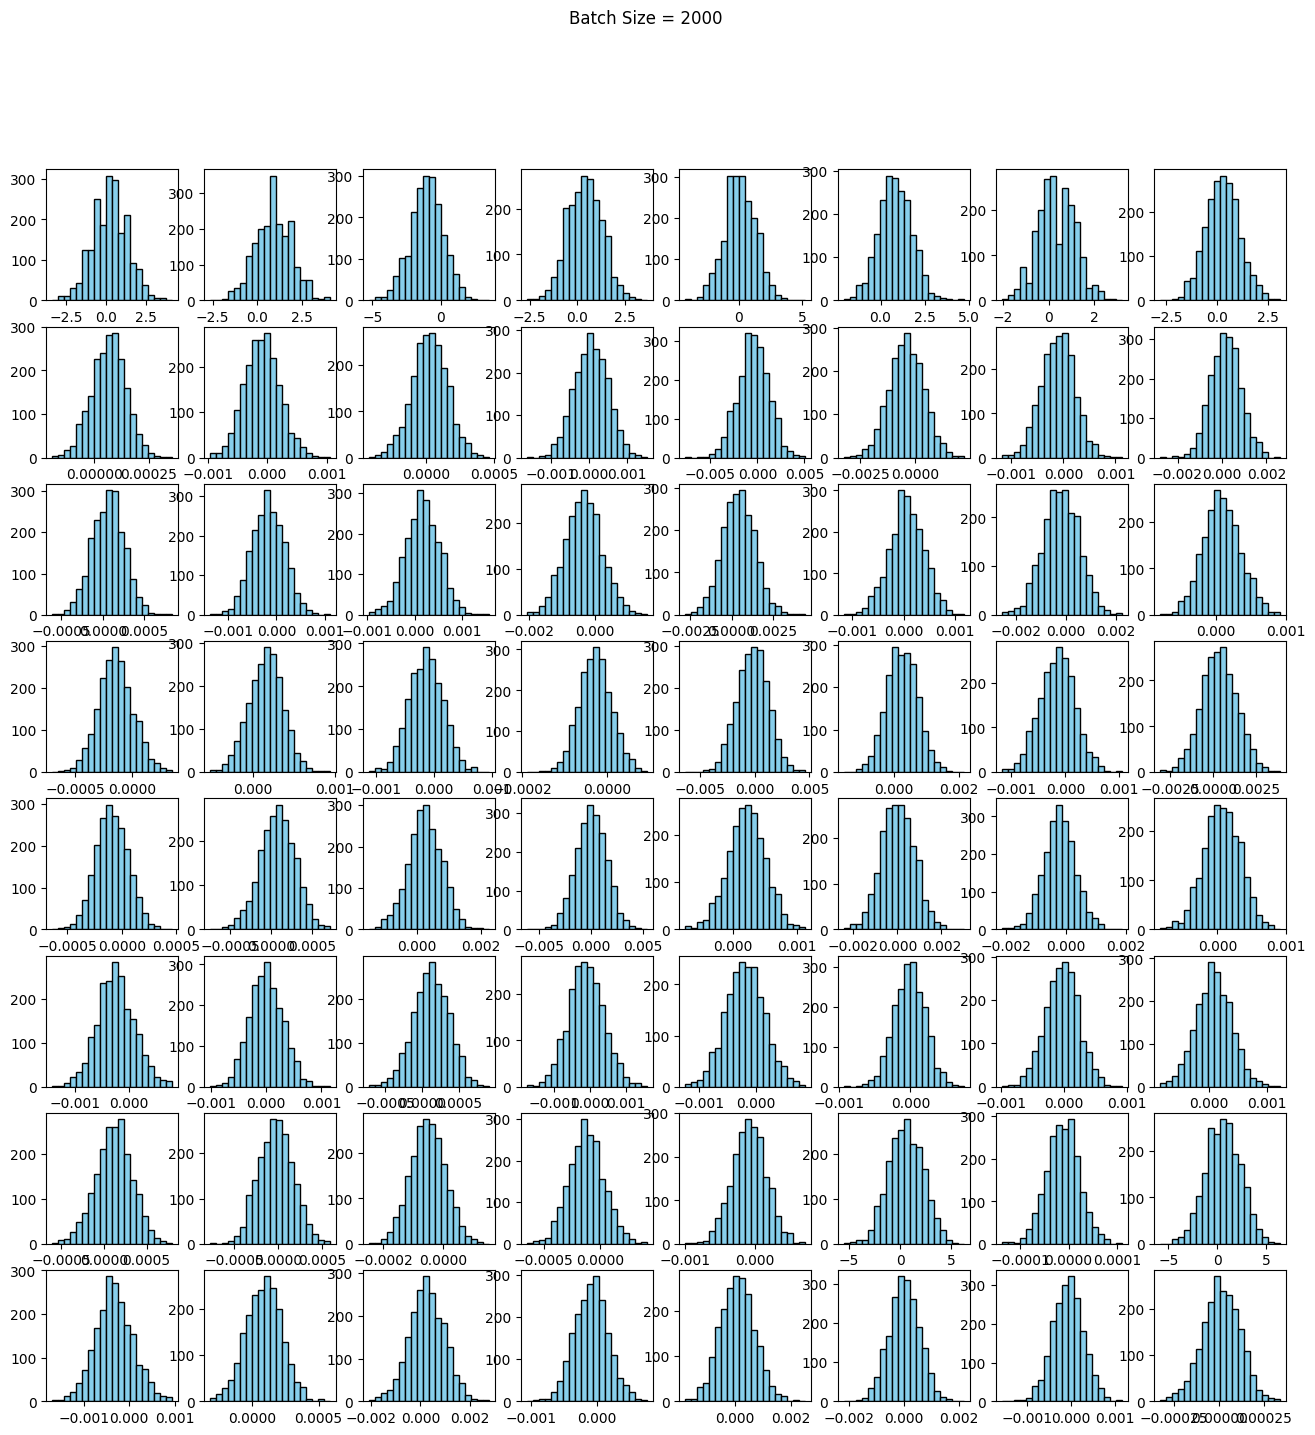

In [24]:
with open(f'./numerical_sim/bi_gaussain/gen_data.pkl', 'rb') as file:
    data = pickle.load(file)
bandwidth_sq = 5.7478714

gates, qubit_inds, param_inds, n_params = get_circuit(8, 3)
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
param_to_mmd_and_grad = value_and_grad(param_to_mmd_stochastic)
random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)
z = jax.random.normal(init_key, shape=(64,))
batch_sizes = [100, 200, 500, 1000, 2000]
_, true_cost_grad = param_to_mmd_and_grad(z, batch_size=5000)
all_hs = []
for _, batch_size in enumerate(batch_sizes):
    hs = []
    for _ in range(2000):
        _, cost_grad = param_to_mmd_and_grad(z, batch_size)
        h = true_cost_grad - cost_grad
        hs.append(np.asarray(h).tolist())
    all_hs.append(hs)
    hs = np.array(hs)
    fig, axs = plt.subplots(8, 8, figsize=(16, 16))
    fig.suptitle(f'Batch Size = {batch_size}')
    for i in range(8):
        for j in range(8):
            axs[i, j].hist(hs[:,i*8+j], bins=20, color='skyblue', edgecolor='black')


2000